## Prediction of Cyber Attacks Using Text as Data

For this assignment I set out to create a model to forecast the incidence of cyber attacks. For data I reached out to the owner of https://www.hackmageddon.com/ for the data he uses to report the statistics on his website. Through literature review I verified this was a reliable source of data since it has been used by other researchers also interested in predicting instances of cyber attacks (please see https://ieeexplore.ieee.org/document/8622106 and https://dl.acm.org/doi/10.1145/3064814.3064831). 

I received a zip file that was a bit of a mess with various folders containing datasets with occasionally inconsistent headers. Please see Hackmageddon_Cleaning.ipynb for the code used to prepare the data. 

I merged this data with the topics from https://conflictforecast.org/downloads. I chose this data because I was curious if hackers would take advantage of times when public discorse was related to certain topics. One could think that perhaps hackers find it opportune to attack a country going through internal turbulence. A proxy for internal turbulence could be when public discorse centers around topics like war or health and emergencies. Or vice versa hackers might find it opportune to attack when a country is going through good times and its companies are failing to prioritze the need for cyber security investments. A proxy for good times could be when public discorse centers around topics such as civilian life or international cooperation.

In [243]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, f1_score
from sklearn.metrics import precision_recall_curve, confusion_matrix

In [186]:
# Get Data

data_dir = '/Users/erikagutierrez/Documents/BSE/Term_3/Nowcasting/Assignments/PSET_1/Data/'

cyber_attacks = pd.read_csv(data_dir + 'monthly_cyber_attacks.csv')
cyber_attacks.drop('Unnamed: 0', axis = 1, inplace = True)
topics = pd.read_csv(data_dir + 'latest_conflictforecast_armedconf_3.csv')

cyber_attacks.rename({'df_index': 'isocode'}, axis = 1, inplace = True)
topics.rename({'year': 'Year', 'month': 'Month'}, axis = 1, inplace = True)

cyber_attacks = pd.merge(cyber_attacks, topics, on = ['Month', 'Year', 'isocode'])

cyber_attacks.rename({'Month':'month', 'Year':'year', 'Attacks':'attacks'}, axis = 1, inplace = True)

cyber_attacks = cyber_attacks[['month', 'year', 'attacks', 'isocode', 'topic0', 'topic1', 'topic2', 'topic3', 'topic4', 'topic5', 'topic6',
               'topic7', 'topic8', 'topic9', 'topic10', 'topic11', 'topic12',
               'topic13', 'topic14']]

My final dataset set contains 132 countries and spans from January 2014 to December 2022, making it 14,247 rows long. It looks like this:

In [187]:
cyber_attacks.sample(10)

,month,year,attacks,isocode,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,topic11,topic12,topic13,topic14
5583,9,2017,1.0,ARE,25.404179,5.680190,4.41116,4.897190,8.295279,7.859140,4.01506,4.019140,0.167620,2.763350,0.16762,27.615189,2.47671,0.48333,1.74484
8777,5,2016,0.0,IRL,18.958981,0.246870,1.53124,13.495291,6.693180,3.213980,1.20235,1.201550,34.042679,5.752510,0.60350,10.713429,1.09407,0.80669,0.44367
11871,1,2014,0.0,JAM,7.652190,3.309230,1.39141,0.464080,4.164070,20.167030,1.35125,8.302310,18.501291,3.663210,0.25188,25.699080,0.25188,1.54548,3.28562
4859,12,2022,0.0,TWN,16.818871,6.040390,24.19315,2.709260,6.988700,0.933490,1.23246,3.010360,1.210050,2.484380,8.81384,13.852390,2.81181,0.60946,8.29141
9537,5,2020,0.0,JOR,24.135571,2.703840,2.88490,0.837530,2.854510,4.996500,2.58037,1.829550,22.216450,1.057210,0.73886,26.870642,4.60280,0.16404,1.52724
12134,6,2016,0.0,BLR,2.418350,18.196291,4.61411,7.438260,8.749619,9.738030,1.58255,18.373499,1.065330,1.354400,7.76364,4.280510,11.45222,1.97333,0.99986
11636,10,2022,0.0,KWT,2.583530,13.240790,8.81244,47.234188,3.628190,5.635910,5.40933,0.656890,1.196740,0.380310,2.38277,0.751480,3.08799,4.61914,0.38031
861,12,2020,0.0,TJK,2.768410,15.682501,0.48586,0.731060,5.200520,14.925850,9.96392,21.265730,0.215220,3.594830,2.28733,3.642990,12.47737,3.07892,3.67949
7568,2,2022,0.0,VEN,7.794930,8.814051,15.45984,10.279880,3.527850,13.116869,2.82978,1.253690,0.737100,7.109030,7.40281,9.266331,11.49218,0.12875,0.78691
5912,9,2022,0.0,MEX,11.310900,2.984350,1.67448,11.079180,11.156120,14.283980,1.25156,6.968190,6.353310,7.723669,3.69048,17.475811,2.09585,1.11395,0.83817


I have the number of cyber attacks that occured at a country by month and year. I think an interesting extension would be to explore how to forecast the number of cyber attacks that will occur or turn the problem into a multi-class prediction one (e.g. forecasting levels of low, medium, and high risk based on number of attacks), but due to time contraints and the scope of this homework I will use a binary classification framework whereby I am forecasting whether a cyber attack will occur in the next 6 months.

Cyber attacks pose a serious problem and can affect various parties ranging from governments, to businesses, to individuals. Cybersecurity Ventures, a lead research group in the global cyber economy, estimates that cybercrime will cost the world $8 trillion annually by 2023. 

For this assignment, the decision maker is the Chief Security Officer (CSO) of a small to mid-size company seeking approval in increasing their budget for cyber security by 25\%. This forecast will provide complementary support for their proposal, since the model can forecast if there will be cyber attacks in their country of operation. If this is the case, it increases the likelihood that an attack is imminent for the company. 

The following articles support my argument that predicting cyber crime is a worthwhile area of research:
 - https://cybersecurityventures.com/cybercrime-to-cost-the-world-8-trillion-annually-in-2023/
 - https://www.ibm.com/downloads/cas/3R8N1DZJ

In [197]:
# Create incidence target variable (in order to turn problem into a classification task)
cyber_attacks['attack_incidence'] = 1
cyber_attacks.loc[cyber_attacks[cyber_attacks['attacks'] == 0].index, 'attack_incidence'] = 0

I will not do feature engineering because the data is already in a format whereby using feature importances retrieved from the random forest classifier, I can analyze my original idea about what topics in public discourse can influence the instances of cyber attacks.

Below I have adapted the notebook provided in class for my use case. 

In [199]:
#this makes the onset variable following the code in the prelude

def make_target(df, t):
    
    # t is the number of periods for the shift

    # loop through each period and generate the shift variables
    for i in range(1, t+1):
        col_name = f'attack_incidence_f{i}'
        df[col_name] = df.groupby('isocode')['attack_incidence'].shift(-i)

    # take the maximum for t periods forward and create the new variable
    df['target_f{}'.format(t)] = df[[f'attack_incidence_f{i}' for i in range(1, t+1)]].max(axis=1, skipna=False)

    # drop the shift variables
    df = df.drop(columns=[f'attack_incidence_f{i}' for i in range(1, t+1)])
    #choosing not to focus on onset
    
    #make the onset variable which ignores periods of ongoing conflict
    #df['ons_target_f{}'.format(t)]=df['target_f{}'.format(t)]

    #df.loc[df['attacks'] >= 1, 'ons_target_f{}'.format(t)] = np.nan
    
    return(df)

In [200]:
#key part of code
def prepare_slice(topics, year, month, deps, forward):
    
    data = cyber_attacks.copy()
    
    #the future data is the data we use to produce the fitted values that are stored
    future = data.drop(data[(data.year != year) | (data.month != month)].index) # drop everything that is not the specified dates
    data = data.drop(data[((data.year > year)) | ((data.year == year) & (data.month >= month))].index) # drop everything that is the specified dates or after 

    #make the target variable through the function above
    #important: this will set to NA the last "forward" observations each country
    data = make_target(data, forward)
    
    features = []
    
    for topic in range(topics):
        features.append('topic' + str(topic))
    
    for dep in deps:
        features.append(dep)
        
        
    features.append('isocode')
    features.append('year')
    features.append('month')
    #features.append('best_model')
    
    #model 1 is the full or augmented model
    data2 = data[features]
    df1 = data2.dropna(how='any')
    df2 = df1[deps]
    #dependent variable for full model
    ys = df2.values.ravel()
    
    #now get the model back
    features.remove(dep)    
    
    #prepare out of sample for the models
    future2 = future[features]
    future_df1 = future2.dropna(how='any')
    
    for feat in ['isocode', 'year', 'month']:
        features.remove(feat)
    
    #training data
    X = df1[features]

    #data at time T for producing fitted values
    X_future = future_df1[features]
    
    #the order here is a bit odd as I added the j (history) model later
    return ys, X, X_future, future_df1

In [201]:
def runsearch(Xs, ys):   
    print("going in")

    model = RandomForestClassifier()
    parameters = {'max_depth': [4, 8],
                  'min_samples_leaf': [50, 100],
                  'n_estimators':[700]}

    grid = GridSearchCV(return_train_score=True, estimator=model, param_grid = parameters, cv = 3, n_jobs=-1, scoring='roc_auc', verbose=2)
    grid.fit(Xs, ys)

    print(grid.best_params_)
    print(grid.best_score_)
    print(grid.cv_results_)
    
    clf=RandomForestClassifier(**grid.best_params_)
    
    return clf

In [202]:
def setparams(treenumber, depthnumber, min_samples_number, min_samples_leaf_number):  
    print("setting parameters")
    print("they are:", treenumber, depthnumber, min_samples_number, min_samples_leaf_number)
    
    clf=RandomForestClassifier(n_estimators=treenumber,  max_depth =depthnumber, 
                               min_samples_split =min_samples_number, min_samples_leaf = min_samples_leaf_number
                             ,n_jobs=8)
    return clf

In [203]:
gendata=1

i = [6]
j = [[8]]

for forward, d1 in zip(i,j):
    
    for depths in d1:
        
        for deps in [[f'target_f{forward}']]:
            
            for min_samples_leafs in [100]:
                
                trees = 700

                topics = 15

                startyearid = 2015
                
                initialize = 1

                min_samples_splits = 2

                search = 0

                if initialize == 1:
                    
                    monthid = 1
                    yearid = startyearid

                    
                    dataslices = prepare_slice(topics, yearid, monthid, deps, forward)
                    
                    
                    fittedvalues = []
                    fittedvalues.append('isocode')
                    fittedvalues.append('year')
                    fittedvalues.append('month')
                    fittedframe = pd.DataFrame(columns=['isocode','year','month'])
                    fittedframe_future=pd.DataFrame(columns=['isocode','year','month'])

                #setting parameters defined above of doing search
                if search==1:
                    
                    print("entering search")
                    clf=runsearch(dataslices[1], dataslices[0])

                else:
                    clf=setparams(trees,depths,min_samples_splits,min_samples_leafs)

                #enter loop
                startyearid=startyearid
                
                for yearid in range(startyearid,2023):
                    
                    if yearid < 2023:
                        
                        maxmonth = 13
                    
                    else:
                        maxmonth = 3

                    
                    for monthid in range(1, maxmonth):
                        
                        print(yearid, monthid)
                        

                        dataslices=prepare_slice(topics, yearid, monthid, deps, forward)
                        
                        df1_future=dataslices[3]

                        fittedvalues=[]
                        fittedvalues.append('isocode')
                        fittedvalues.append('year')
                        fittedvalues.append('month')  
                        fittedframe_future = df1_future[fittedvalues]

                        clf.fit(dataslices[1], dataslices[0])
                        res = clf.predict_proba(dataslices[2])
                        pred_label = clf.predict(dataslices[2])
                        fittedframe_future[deps[0]+'_pred'] = res[:,1]
                        fittedframe_future[deps[0]+'_pred_label'] = pred_label

                        fittedframe=pd.concat([fittedframe,fittedframe_future])
                
                gendata=1
                
                fittedframe.to_csv("{}_predictions.csv".format(deps[0]))

setting parameters
they are: 700 8 2 100
2015 1


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2015 2


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2015 3


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2015 4


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2015 5


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2015 6


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2015 7


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2015 8


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2015 9


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2015 10


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2015 11


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2015 12


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2016 1


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2016 2


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2016 3


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2016 4


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2016 5


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2016 6


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2016 7


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2016 8


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2016 9


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2016 10


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2016 11


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2016 12


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2017 1


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2017 2


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2017 3


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2017 4


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2017 5


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2017 6


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2017 7


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2017 8


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2017 9


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2017 10


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2017 11


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2017 12


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2018 1


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2018 2


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2018 3


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2018 4


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2018 5


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2018 6


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2018 7


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2018 8


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2018 9


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2018 10


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2018 11


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2018 12


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2019 1


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2019 2


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2019 3


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2019 4


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2019 5


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2019 6


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2019 7


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2019 8


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2019 9


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2019 10


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2019 11


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2019 12


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2020 1


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2020 2


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2020 3


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2020 4


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2020 5


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2020 6


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2020 7


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2020 8


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2020 9


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2020 10


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2020 11


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2020 12


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2021 1


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2021 2


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2021 3


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2021 4


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2021 5


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2021 6


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2021 7


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2021 8


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2021 9


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2021 10


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2021 11


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2021 12


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2022 1


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2022 2


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2022 3


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2022 4


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2022 5


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2022 6


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2022 7


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2022 8


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2022 9


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2022 10


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2022 11


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


2022 12


/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred'] = res[:,1]
/var/folders/w6/q5_zm221051fpvtg0kr3dy480000gn/T/ipykernel_53544/1309178710.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fittedframe_future[deps[0]+'_pred_label'] = pred_label


#### Let's review the outcomes of the model

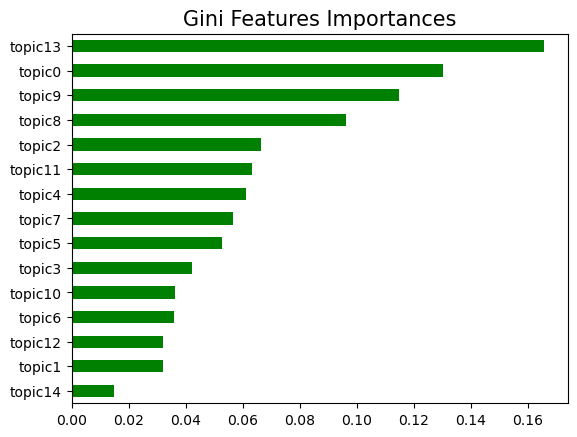

In [228]:
importances_clf = pd.Series(data = clf.feature_importances_,
                                index= clf.feature_names_in_)

importances_sorted_clf = importances_clf.sort_values()

importances_sorted_clf.plot(kind='barh', color='green')
plt.title('Gini Features Importances', size=15)
plt.show()

This graph indicates there might be relationship between public discourse being focused on foreign policy and the increased likelihood of cyber attacks. 

In [246]:
# Model Assessment
#merging fitted values back to main data to be able to calculate performance
data = cyber_attacks.copy()

for deps in [[f'target_f{forward}']]:
    
    my_file = Path("{}_predictions.csv".format(deps[0]))

    predictions=pd.read_table(my_file, sep=',')

    fittedvalues=predictions.dropna(subset=['{}_pred'.format(deps[0]), f'{deps[0]}_pred_label'])

    data = data.merge(fittedvalues, how='right', on=['isocode', 'year', 'month'])
    
    data.drop('Unnamed: 0', axis = 1, inplace = True)


#add dependent variables again
combined=make_target(data, forward)


restricted=combined.dropna(subset=['target_f6','target_f6_pred', 'target_f6_pred_label'])
#restricted=restricted[restricted["anyviolence_3"]>=monthsince]
y_true=restricted['target_f6']
y_scores=restricted['target_f6_pred']
y_pred_labels = restricted['target_f6_pred_label']
print("observations:", len(y_true))
print("model AUC:", roc_auc_score(y_true, y_scores), "and av.precision:", average_precision_score(y_true, y_scores))
print("model F1:", f1_score(y_true, y_pred_labels))

observations: 11874
model AUC: 0.7480431782847791 and av.precision: 0.6516304051414905
model F1: 0.4569687738004569


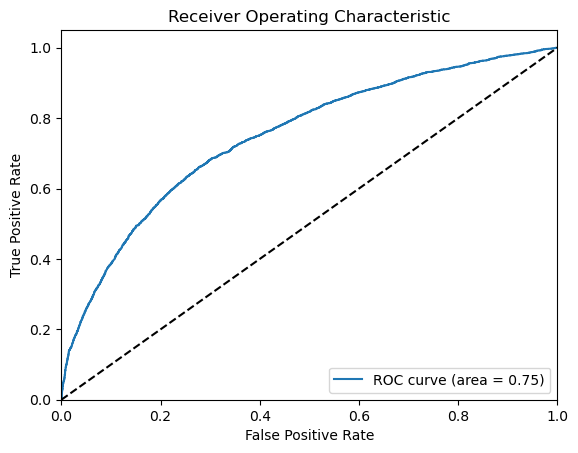

In [219]:
# Compute the false positive rate (FPR), true positive rate (TPR), and threshold
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Compute the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Plotting the diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

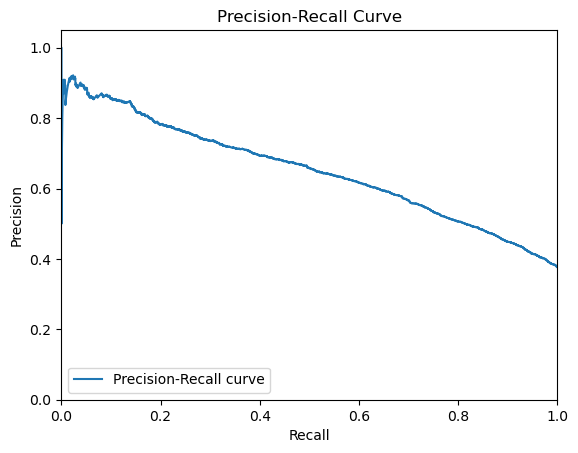

In [220]:
# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Plotting the Precision-Recall curve
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower left")
plt.show()

The model has an AUC score of .75. The AUC is a number between 0 and 1, that is the ratio of the True Positive Rate over the False Positive Rate. True Positive Rate, also referred to as recall, is a measure of the model's ability to correctly classify instances of cyber attacks in the next 6 months. The False Postive Rate can be interpreted as the probability of incorrectly classifying that there will be an instance of a cyber attack in the next 6 months. In the graph this ratio is plotted using the probability estimates of the cyber attack prediction compared to an array of thresholds ranging from 0 to in this case .811. The AUC of .75 means the model has the capability to distinguish between times where there will be no cyber attack and times there will be a cyber attack with an accuracy of 75%. 

But this may paint an overly optimistic view of model performance since it does not take into account class imbalance. Therefore we look at the precision recall curve.

Similar to the ROC curve, in the precision recall curve the probability estimates of the cyber attack prediction are compared to an array of thresholds. However, this graph is meant to show the tradeoff between precision and recall in the model. Precision meaning, all predicted cyber attacks were actually cyber attack (this metric does not factor in predictions of cyber attacks when there actually were none). Recall meaning, all instances of true cyber attacks were classified as cyber attack (this metric does not take into account when it was predicted there would be no cyber attack but there was). In other words a higher precision will result in a low false postive rate but a high recall will result in a lower false negative rate. 

The CSO will probably care most about the the false positve rate of the model. Since they do not want to raise the alarm of a cyber attack and ask for more money when there is relatively low risk. However, a false negative is more costly to the company since the cost of a cyber attack is more than the investment to prevent it. Either way the CSO is on the hook, but they may want a model with high precision relative to recall. 

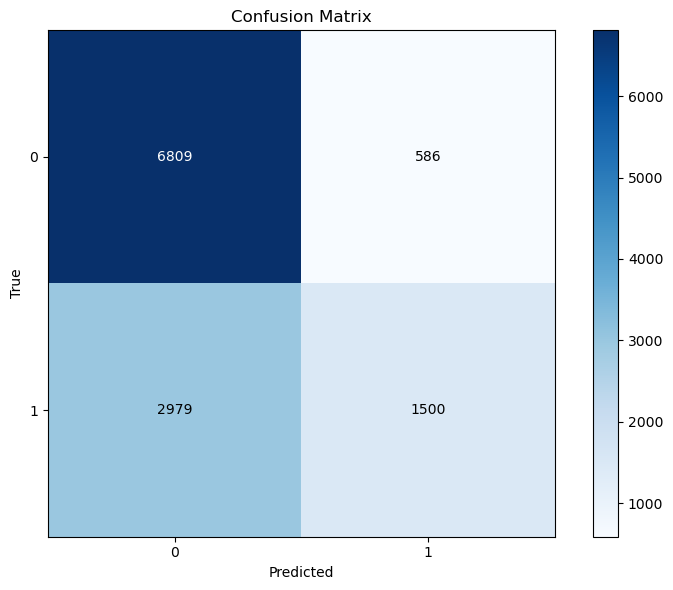

true_negatives: 6809
false_positives: 586
false_negatives: 2979
true_positives: 1500


In [221]:
# full model confusion matrix
classes = [0,1]

cm = confusion_matrix(y_true, y_pred_labels)


plt.figure(figsize=(8, 6))
ax = plt.subplot()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)


ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')


tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'), ha='center', va='center',
                color='white' if cm[i, j] > thresh else 'black')


plt.tight_layout()
plt.show()


true_negatives = cm[0, 0]
false_positives = cm[0, 1]
false_negatives = cm[1, 0]
true_positives = cm[1, 1]


print('true_negatives:', true_negatives)
print('false_positives:', false_positives)
print('false_negatives:', false_negatives)
print('true_positives:', true_positives)

In [222]:
# True Positives: Correctly identified that there would be a cyber attack in the next six months
# True Negatives: Correctly identifed that there would not be a cyber attack in the next six months
# False Positives: Identified that were would be a cyber attack in the next six months when there wouldn't be
# False Negatives: Identified that there wouldn't be a cyber attack when there was one

The structure of the cost function introduced in class makes sense for the CSO assuming that there is only one chance to propose the budget for the next 6 months. The use case is: they are drafting their budget for the next 6 months, they run the model and it provides them with the predicted probability of a cyber attack happening in the next 6 months in the country they are operating in, if the predicted probability of an attack is past a certain threshold then they ask for additional money in their budget that will go towards cyber security investments. 

Below I have written the functions necessary to implement the minimization of the cost function. The evaluate_cutoffs loops through the predicted proabilities of a cyber attack happening in the next 6 months for each year and month and compares it against a threshold and returns the number of true positives, true negatives, false positives, false negatives. These values are then given to the evaluate_cost_fn that also takes as arguments the cost of a cyber attack on the company, the cost of intervention (the cost of the original cyber security budget plus the 25\% increase), and an intervention effectiveness estimation which I have set to .75. Meaning with this additional money in the cyber security budget a cyber attack will be prevented with a proability of 75\%

Based on these calculations, the optimal threshold to ask for additional money in the budget is when the risk predicted by the model is just below 30\%

This is a relatively low threshold, but I think its because since the cost of intervention is so low relative to the cost of an attack on the company, the decision maker can afford to have more false positives.

In [252]:
def evaluate_cutoffs(cutoff, predict_probas, true_class):
    
    y_pred_labels = [1 if x > cutoff else 0 for x in predict_probas]
    cm = confusion_matrix(y_true, y_pred_labels)

    true_negatives = cm[0, 0]
    false_positives = cm[0, 1]
    false_negatives = cm[1, 0]
    true_positives = cm[1, 1]
    
    return true_positives, true_negatives, false_positives, false_negatives       

def evaluate_cost_fn(outbreak_cost, intervention_cost, p, TP, FP, FN, TN):
    
    # discounted cost of no intervention (peace) is 0
    peace = 0
    
    cost = (((p * peace) + ((1 - p) * outbreak_cost) + intervention_cost) * TP) + ((peace + intervention_cost) * FP) + (outbreak_cost * FN) + (peace * TN)
    
    return cost   

In [240]:
# outbreak and intervention costs take from this article: https://www.sangfor.com/blog/cybersecurity/cost-of-cybercrime-vs-cost-of-cybersecurity

outbreak = 2980000 # the average cost of a cyber attack on a small business
intervention = 500000 + 125000 # average cyber security budget of a small business plus a 25% increase
effectiveness = .75

costs = []

for c in thresholds:
    true_positives, true_negatives, false_positives, false_negatives = evaluate_cutoffs(c, y_scores, y_true)
    costs.append(evaluate_cost_fn(outbreak, 
                                  intervention, 
                                  effectiveness, 
                                  true_positives, false_positives,
                                 false_negatives, true_negatives))

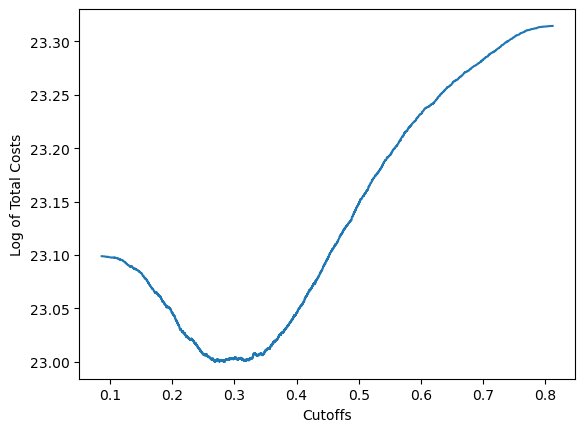

In [242]:
plt.plot(thresholds, np.log(costs))
plt.xlabel('Cutoffs')
plt.ylabel('Log of Total Costs')
plt.show()

In [250]:
true_positives, true_negatives, false_positives, false_negatives = evaluate_cutoffs(.28, y_scores, y_true)